In [1]:
from utils import read_mocap_joints, read_mocap_marker, read_mocap_setup, read_subject

path = "recordings/18-12-24--12-39-20"
print(read_subject(path))

Finn


In [2]:
import numpy as np
import matplotlib.pyplot as plt 

600.09


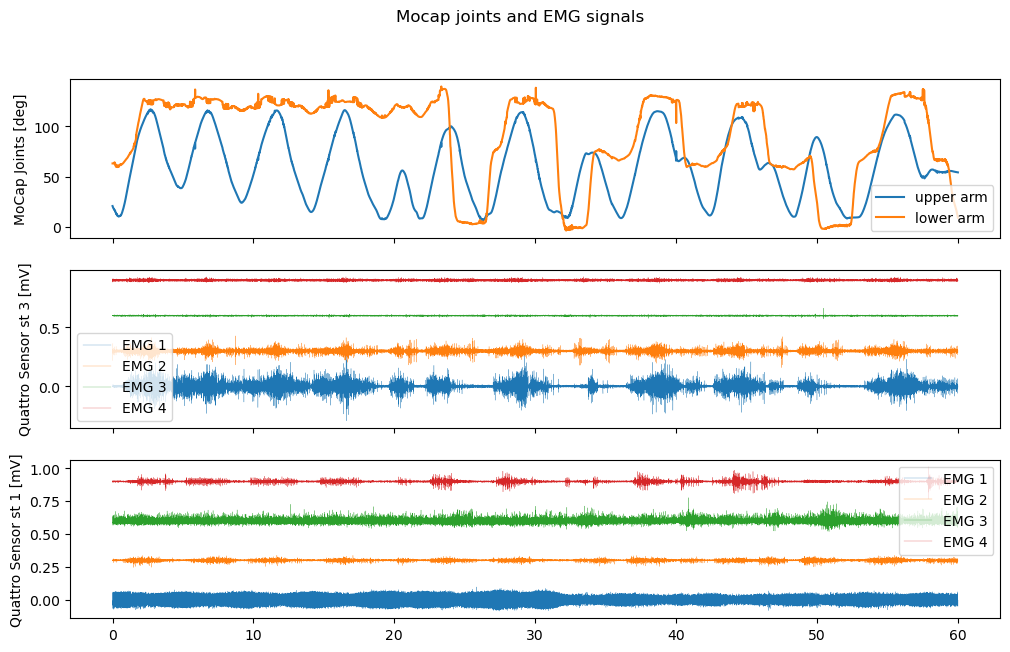

In [3]:
from Plotter import plot_dataset, plot_joints
fig = plt.figure(figsize=(12, 7))
fig.suptitle("Mocap joints and EMG signals")
plot_dataset(path, (True, False, False, True), t_crop=(10, 70), fig=fig)

## How to handle leaps in the data

600.09


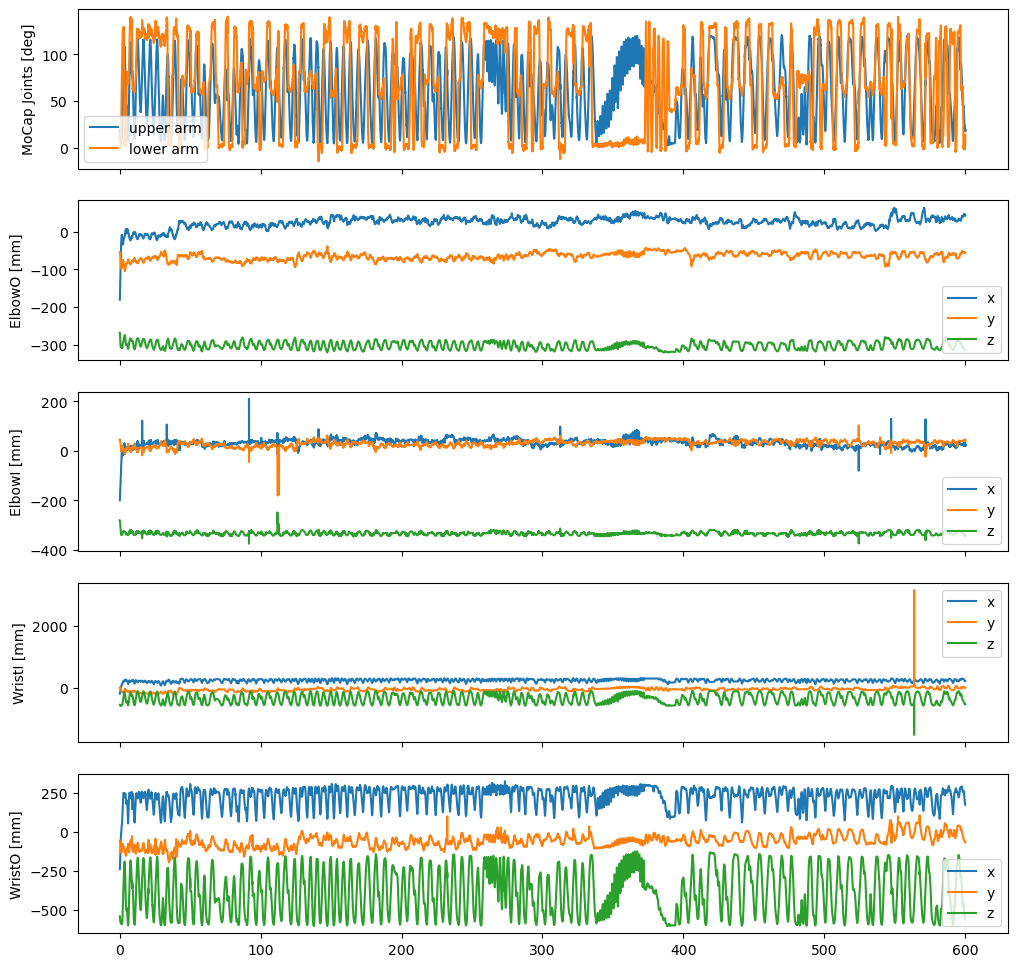

In [4]:
fig = plt.figure(figsize=(12, 12))
plot_dataset(path, (True, False, True, False), 
             fig=fig, markers=("ElbowO", "ElbowI", "WristI", "WristO"), 
            # t_crop=(130, 230)
            )

In [5]:

from operator import itemgetter

joint_data = read_mocap_joints(path)["joints"]
joint_data = np.where(joint_data == -999, np.nan, joint_data) # where important markers were predicted
marker_pred, marker = itemgetter("marker_prediction", "mocap")(read_mocap_marker(path))

In [6]:
marker_labels = [x[0] for x in read_mocap_setup(path)["Markers"]]
marker_labels

['ShoulderB',
 'ShoulderF',
 'ElbowO',
 'UpperArm',
 'ElbowI',
 'WristO',
 'WristI',
 'LowerArm1',
 'LowerArm2',
 'WristL',
 'Hand']

## Filter Using Markers

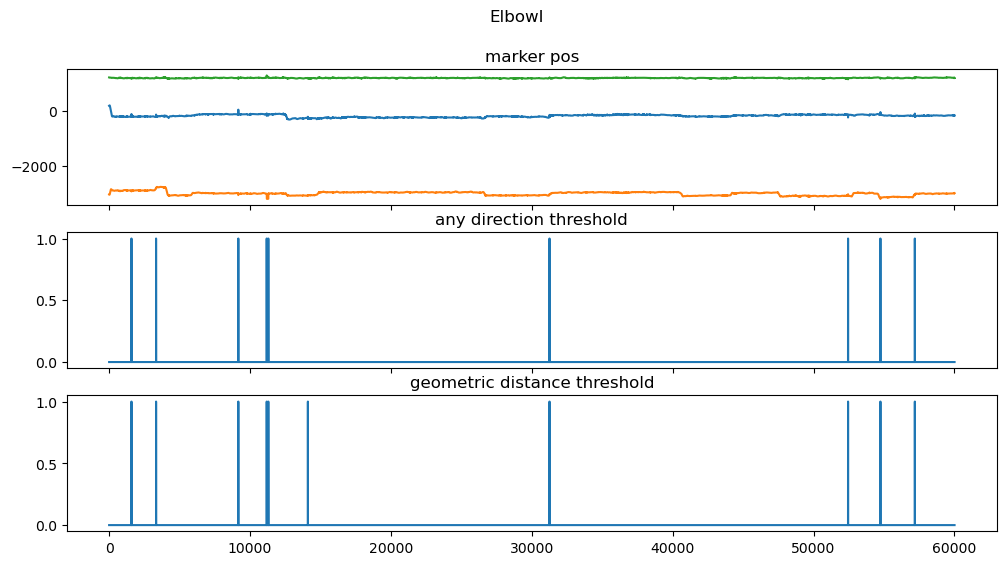

In [7]:
i = 4
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)
fig.suptitle(marker_labels[i])
axs[0].plot(marker[:, i, :])
axs[1].plot(np.any(np.diff(marker, axis=0)[:, i, :] > 50, axis=1))
axs[2].plot(np.sqrt(np.sum((marker[1:, :, :] - marker[:-1,:,:])**2, axis=2))[:,i] > 50)
axs[0].set_title("marker pos")
axs[1].set_title("any direction threshold")
axs[2].set_title("geometric distance threshold")
plt.show()

## Filter using Calculated joints directly

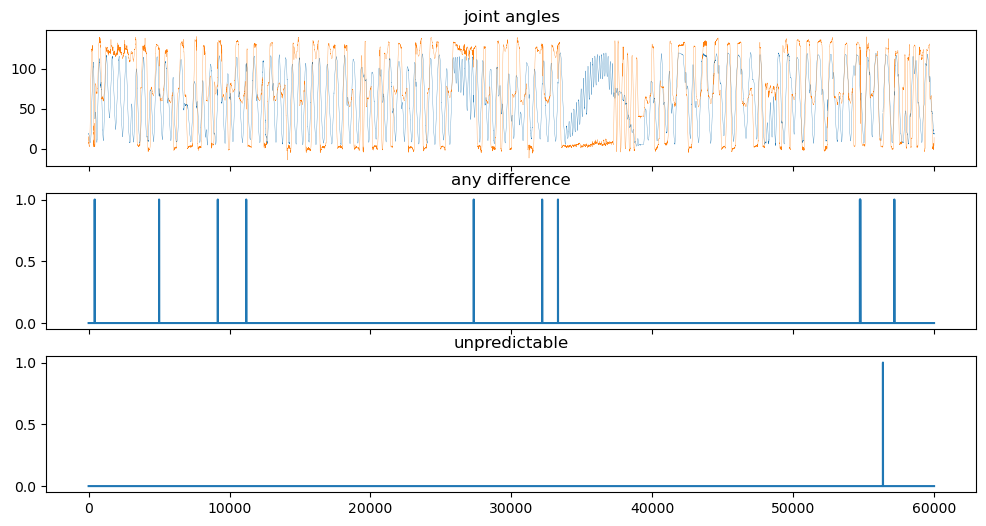

In [8]:
fig, axs = plt.subplots(3, figsize=(12, 6), sharex=True)
axs[0].plot(joint_data, lw=0.2)
axs[1].plot(np.any(np.diff(joint_data, axis=0) > 20, axis=1))
axs[2].plot(np.any(marker_pred == 0, axis=1))
axs[0].set_title("joint angles")
axs[1].set_title("any difference")
axs[2].set_title("unpredictable")
plt.show()

-2:     no need to predict as marker is only for redundancy \
-1:     predicted \
0:      unable to predict or occluded \
1:      not occluded

## Combine all

In [9]:
imp_marker_idx = [0, 1, 2, 4, 5, 6]

In [10]:
mask = (
    np.any(np.sqrt(np.sum((marker[1:, :, :] - marker[:-1,:,:])**2, axis=2))[:, imp_marker_idx] > 50, axis=1) | 
    np.any(marker_pred[:-1] == 0, axis=1) |
    np.any(np.diff(joint_data, axis=0) > 30, axis=1)
)
mask = np.where(mask)[0]
mask

array([  864,   865,   866,   868,   869,   870,  1585,  1586,  2032,
        2034,  2531,  2532,  3332,  3333,  4003,  4004,  4998,  4999,
        5000,  9169,  9170,  9410,  9411,  9415,  9416, 11185, 11186,
       11300, 14107, 14108, 23238, 23239, 26812, 26814, 27055, 27056,
       27057, 27058, 27327, 27328, 27330, 27332, 27334, 27335, 27336,
       31257, 31258, 32183, 32189, 32190, 33309, 33312, 33313, 52446,
       52448, 54744, 54745, 54769, 54770, 55234, 55235, 56377, 56378,
       56379, 56767, 56768, 57187, 57188])

In [11]:
mask = [0] + list(mask) + [joint_data.shape[0]]
bundles = []
for i, diff in enumerate(np.diff(mask)):
    if diff > 1000: 
        bundles.append(joint_data[mask[i] + 1: mask[i+1] - 1, :])

In [12]:
print(sum([b.shape[0] for b in bundles]), joint_data.shape[0], len(bundles))

51858 60009 11


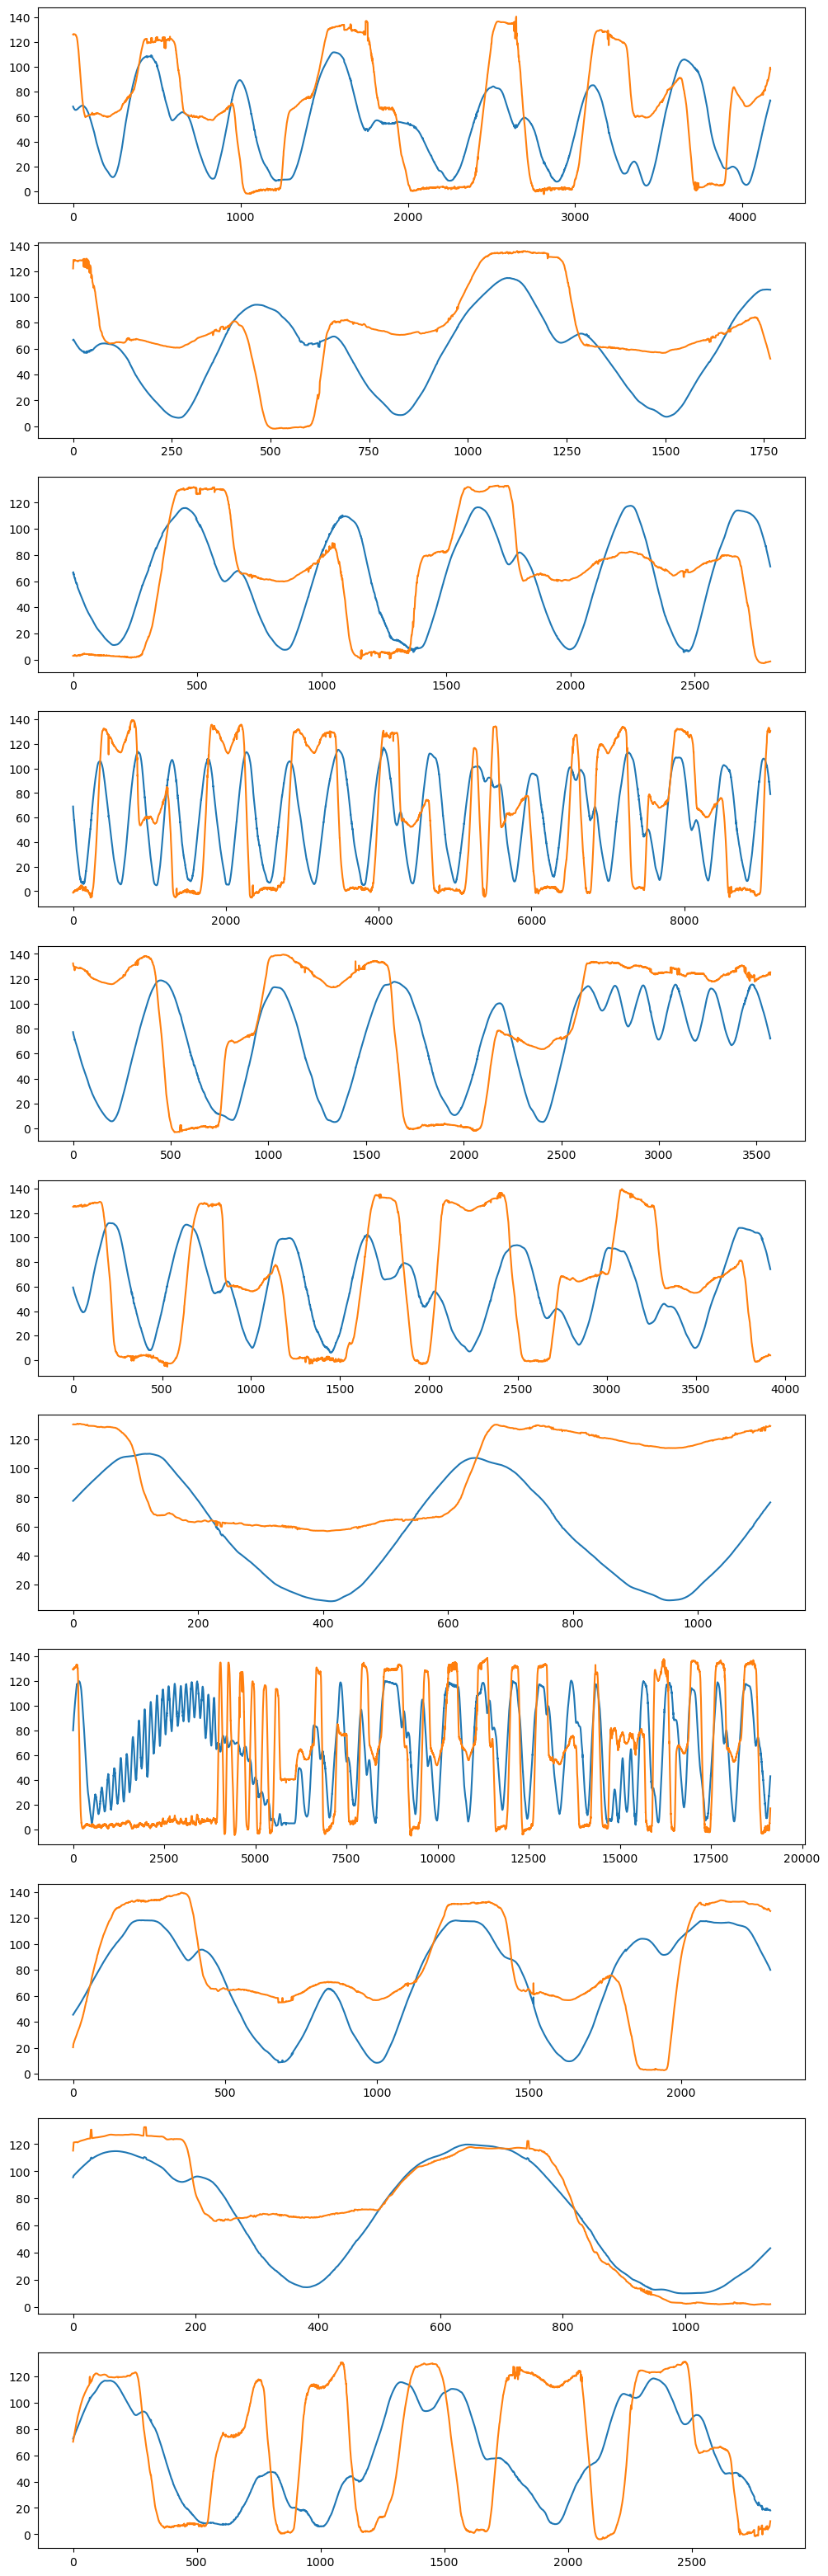

In [13]:
fig, axs = plt.subplots(len(bundles), figsize=(12, 40))
for (ax, bundle) in zip(axs, bundles): 
    ax.plot(bundle)

In [14]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

2024-12-18 18:28:48.183638: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 18:28:48.284419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734542928.324566   84326 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734542928.335423   84326 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 18:28:48.427930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
